
### T2 Data Analysis  

        Sean Keenan, PhD Physics  
        Quantum Memories Group, Heriot-Watt University, Edinburgh  
        2021  

In [1]:
import os
import spec_funcs as sf
import fit_funcs as ff
import numpy as np
import pandas as pd
import matplotlib.pyplot as mp
mp.style.use('signature.mplstyle')

path = r"C:\Users\sk88\Desktop\YSO_T1"


##### Import Data  

        Load data sets & extract time and voltage data


In [2]:
_, files = sf.dir_interogate(path)
file_paths = [os.path.join(path, x) for x in files]
data_sets = [pd.read_csv(file_path) for file_path in file_paths]
data = [[data_set[x].values.tolist() for x in data_set] for data_set in data_sets]
length = range(len(data))
time = [data[n][0] for n in length]
trigger = [data[n][1] for n in length]
reference = [data[n][2] for n in length]
transmitted = [data[n][3] for n in length]

In [3]:
trig_index = [int(sf.find_trigger(trig_set, np.max(trig_set) * 0.99)) for trig_set in trigger]
mins = [min(trans_set) for trans_set in transmitted]
maxs = [max(trans_set) for trans_set in transmitted]
trans_corrected = [[value - min for value in trans_set] for trans_set, min in zip(transmitted, mins)]
trans_norm = [[value / max if value != 0 else value for value in trans_set] for trans_set, max in zip(trans_corrected, maxs)]

In [4]:
set = 5

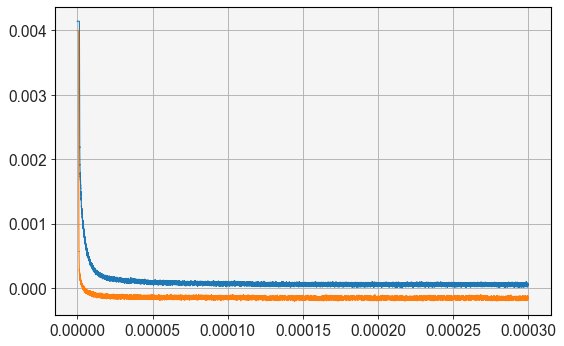

In [5]:
fig, ax = mp.subplots()
ax.plot(time[set], trans_corrected[set])
ax.plot(time[set], reference[set])

In [6]:
bounds = ([1, 140E-6, 0, mins[set]], [np.inf, 170E-6, np.inf, np.inf])

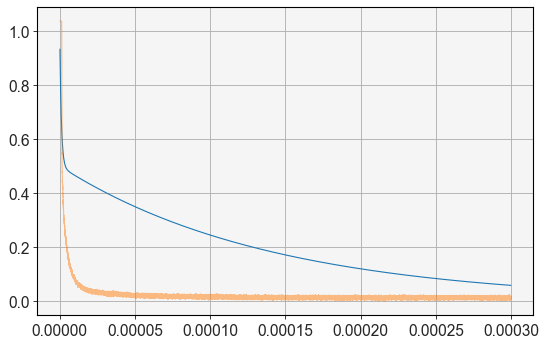

In [7]:
test, error = ff.fit_dbl_exp_decay(x=time[set][trig_index[set]:-1], y=trans_norm[set][trig_index[set]:-1], params=(np.max(trans_norm[set][trig_index[set]:-1]), 160E-6, 10E-6, mins[set]), lims=bounds, meth='trf')
test_fit = ff.dbl_exp_decay(np.array(time[set][trig_index[set]:-1]), *test)
fig, ax = mp.subplots()
#ax.plot(time[0][trig_index[0]:-1], ln_data[0][trig_index[0]:-1])
ax.plot(time[set][trig_index[set]:-1], test_fit)
ax.plot(time[set][trig_index[set]:-1], trans_norm[set][trig_index[set]:-1], alpha = 0.5)

In [8]:
bounds_1 = ([0.8, 140E-6, mins[set]], [np.inf, 170E-6, np.inf])

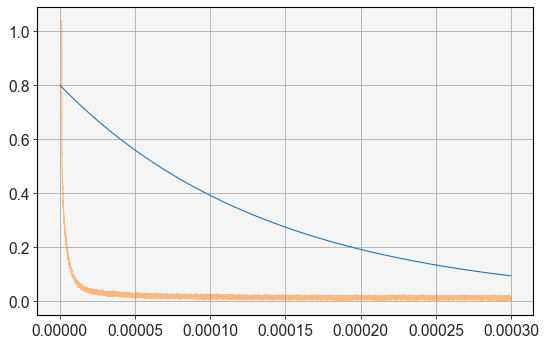

In [10]:
test_1, error_1 = ff.fit_exp_decay(x=time[set][trig_index[set]:-1], y=trans_norm[set][trig_index[set]:-1], params=(np.max(trans_norm[set][trig_index[set]:-1]), 160E-6, mins[set]), lims=bounds_1, meth='trf')
test_fit_1 = ff.exp_decay(np.array(time[set][trig_index[set]:-1]), *test_1)
fig, ax = mp.subplots()
#ax.plot(time[0][trig_index[0]:-1], ln_data[0][trig_index[0]:-1])
ax.plot(time[set][trig_index[set]:-1], test_fit_1)
ax.plot(time[set][trig_index[set]:-1], trans_norm[set][trig_index[set]:-1], alpha = 0.5)

In [ ]:
log_fit = np.log(test_fit)
log_data = np.log(trans_norm[set][trig_index[set]:-1])

fig, ax = mp.subplots()
ax.plot(log_fit, 'x')
ax.plot(log_data, 'x')

In [ ]:
test, error